# **Prediksi Polusi Udara**

## **Import Library**

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM

## **Load Dataset**

In [4]:
df = pd.read_csv('final.csv')

df.head()

,created_at,entry_id,field1,field2,latitude,longitude,elevation,status
0,2024-12-11T12:41:13+00:00,1,402.81,0.64,NaN,NaN,NaN,NaN
1,2024-12-11T12:41:29+00:00,2,402.69,0.65,NaN,NaN,NaN,NaN
2,2024-12-11T12:41:45+00:00,3,402.76,0.64,NaN,NaN,NaN,NaN
3,2024-12-11T12:42:01+00:00,4,402.66,0.65,NaN,NaN,NaN,NaN
4,2024-12-11T12:42:17+00:00,5,402.66,0.65,NaN,NaN,NaN,NaN


In [5]:
df.drop(columns=['latitude', 'longitude', 'elevation', 'status'], inplace=True)

df.head()

,created_at,entry_id,field1,field2
0,2024-12-11T12:41:13+00:00,1,402.81,0.64
1,2024-12-11T12:41:29+00:00,2,402.69,0.65
2,2024-12-11T12:41:45+00:00,3,402.76,0.64
3,2024-12-11T12:42:01+00:00,4,402.66,0.65
4,2024-12-11T12:42:17+00:00,5,402.66,0.65


In [6]:
df.rename(columns={'field1': 'CO2', 'field2': 'CO'}, inplace=True)

df.tail(3)

,created_at,entry_id,CO2,CO
160782,2025-01-12T01:09:41+00:00,160783,424.71,0.80
160783,2025-01-12T01:09:57+00:00,160784,425.55,0.80
160784,2025-01-12T01:10:13+00:00,160785,431.22,0.81


In [7]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160785 entries, 0 to 160784
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   created_at  160785 non-null  datetime64[ns, UTC]
 1   entry_id    160785 non-null  int64              
 2   CO2         160785 non-null  float64            
 3   CO          160785 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1)
memory usage: 4.9 MB


## **Exploratory Data Analysis**

Mengubah created at sebagai index dari data frame

In [9]:
# Set kolom 'created_at' sebagai index
df = df.set_index('created_at')

Visualisasi data CO2 sebelum dilakukannya resampling maupun preprocessing

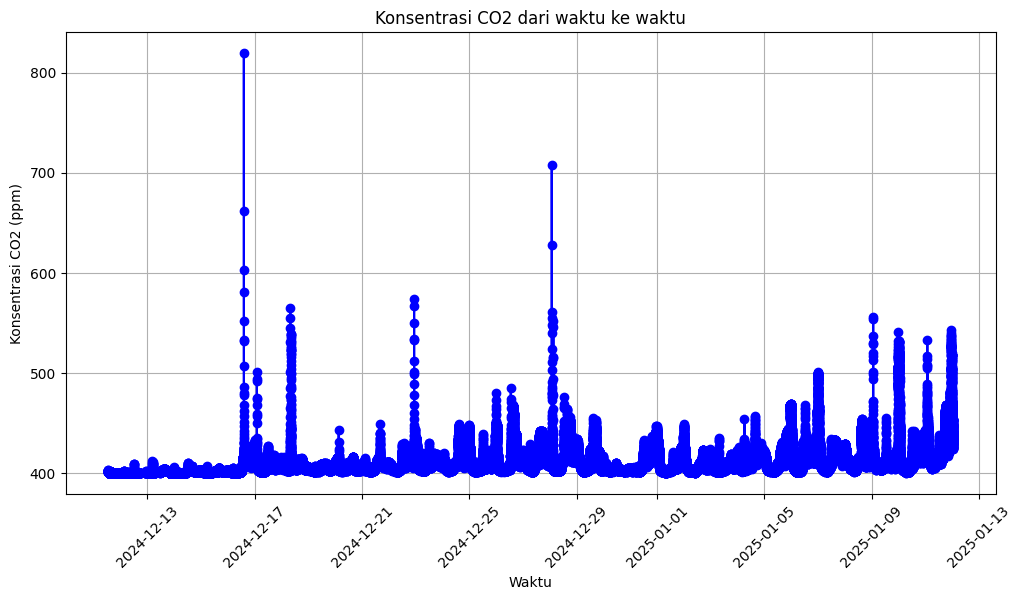

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['CO2'], marker='o', color='blue')
plt.title('Konsentrasi CO2 dari waktu ke waktu')
plt.xlabel('Waktu')
plt.ylabel('Konsentrasi CO2 (ppm)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


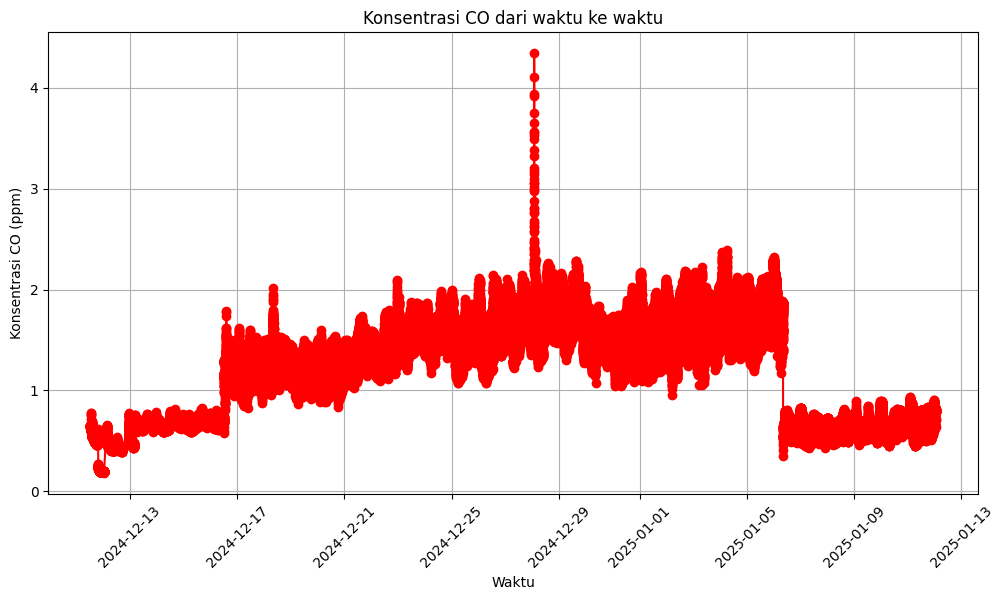

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df['CO'], marker='o', color='red')
plt.title('Konsentrasi CO dari waktu ke waktu')
plt.xlabel('Waktu')
plt.ylabel('Konsentrasi CO (ppm)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


Melakukan resampling per 2 menit dengan tujuan untuk dapat meningkatkan tren dari data dan mengurangi nilai outliers akibat dari kesalahan bada pada data sensor

In [13]:
# Resample per menit, ambil mean (rata-rata) untuk setiap menit
df_per_2menit = df.resample('2min').mean()
# df_per_2menit = df_per_2menit.round(2) # membulatkan pembacaan sensor menjadi 2 desimal
df_per_2menit.head()

,entry_id,CO2,CO
created_at,,,
2024-12-11 12:40:00+00:00,2.0,402.753333,0.643333
2024-12-11 12:42:00+00:00,7.5,402.695000,0.646250
2024-12-11 12:44:00+00:00,14.5,402.726667,0.655000
2024-12-11 12:46:00+00:00,NaN,NaN,NaN
2024-12-11 12:48:00+00:00,NaN,NaN,NaN


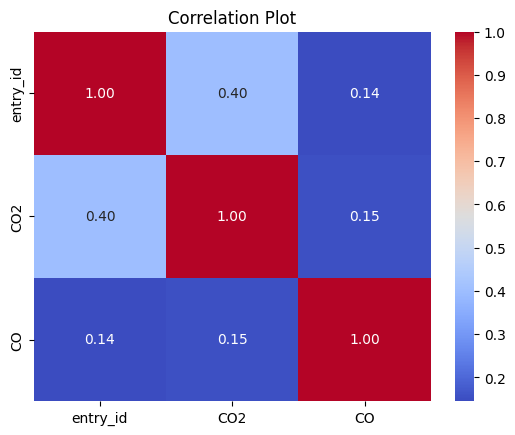

In [15]:
correlation = df_per_2menit[['entry_id','CO2', 'CO']].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Plot')
plt.show()

Dapat terlihat data dari entry id kurang relevan untuk melakukan prediksi polusi udara maka dari itu kolom entry_id akan di drop

In [16]:
df_per_2menit.drop(columns=['entry_id'], inplace=True)

df_per_2menit.head(1)

,CO2,CO
created_at,,
2024-12-11 12:40:00+00:00,402.753333,0.643333


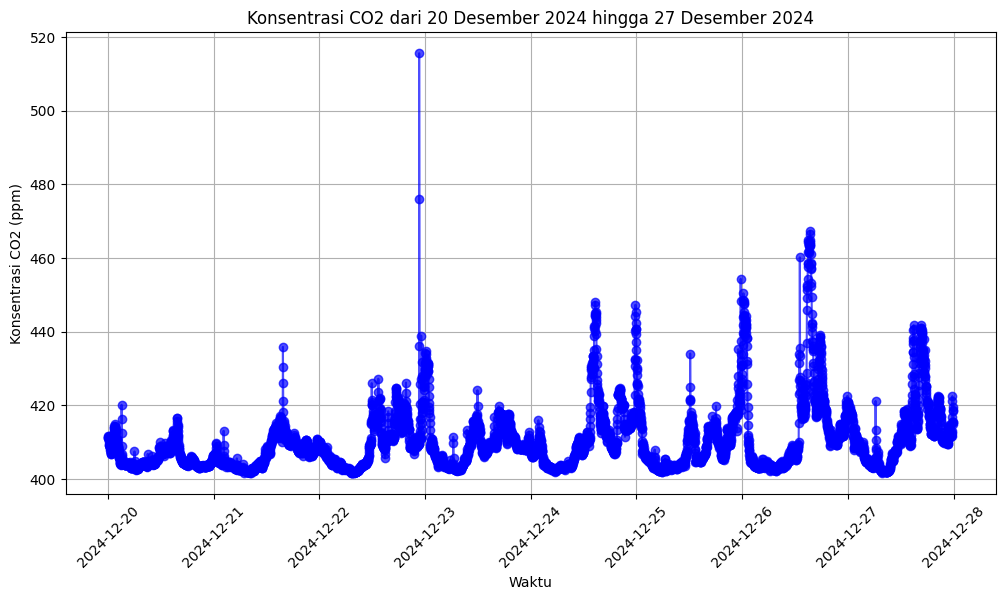

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df_per_2menit['CO2']['2024-12-20':'2024-12-27'].round(2), marker='o', color='blue', alpha=0.7)
plt.title('Konsentrasi CO2 dari 20 Desember 2024 hingga 27 Desember 2024')
plt.xlabel('Waktu')
plt.ylabel('Konsentrasi CO2 (ppm)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

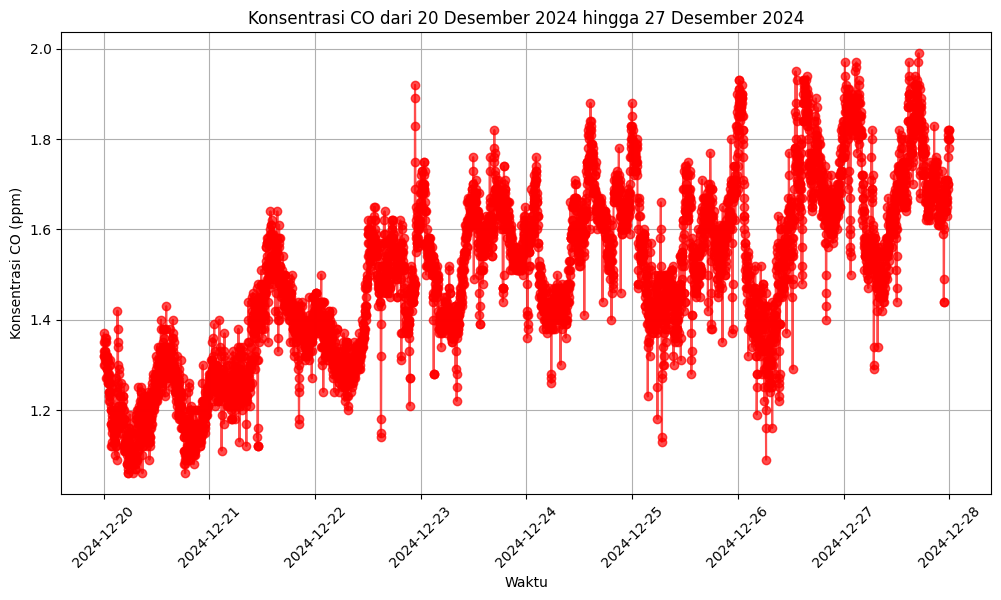

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df_per_2menit['CO']['2024-12-20':'2024-12-27'].round(2), marker='o', color='red', alpha=0.7)
plt.title('Konsentrasi CO dari 20 Desember 2024 hingga 27 Desember 2024')
plt.xlabel('Waktu')
plt.ylabel('Konsentrasi CO (ppm)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

Graph CO dan CO2 untuk di input di tugas akhir

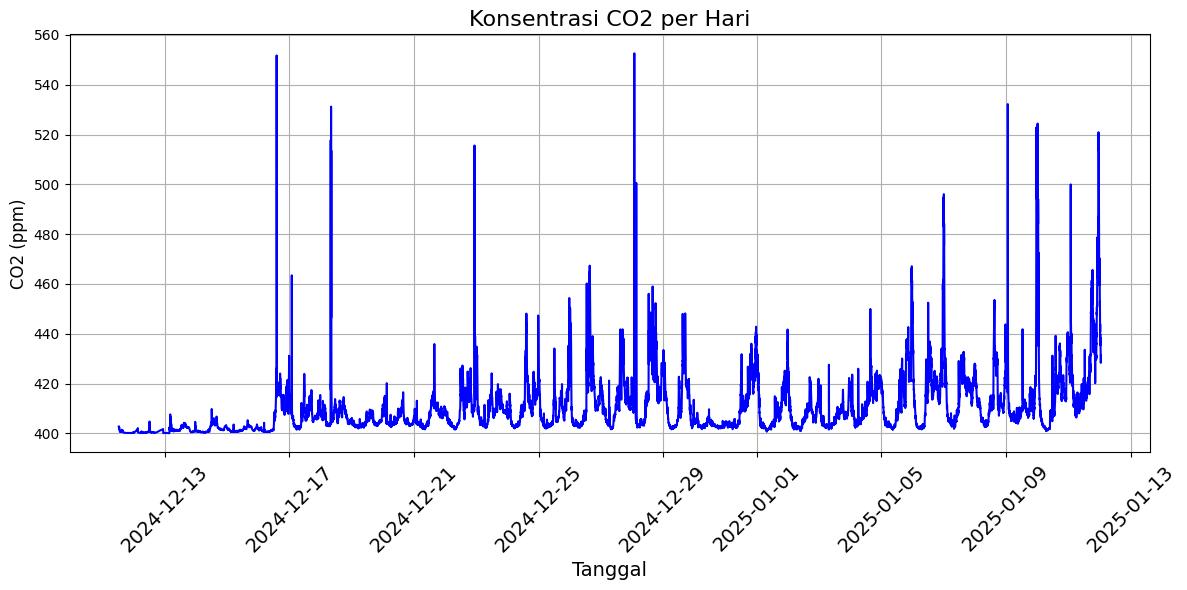

In [23]:
plt.figure(figsize=(12, 6))  # Ukuran besar agar resolusi bagus
sns.lineplot(data=df_per_2menit, x='created_at', y='CO2', color='blue', markers='o')

# Tambahan estetika
plt.title('Konsentrasi CO2 per Hari', fontsize=16)
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.xticks(rotation=45, fontsize=14)
plt.grid(True)

# Simpan dalam kualitas tinggi
plt.tight_layout()
plt.savefig("co2_plot.png", dpi=300)
plt.show()

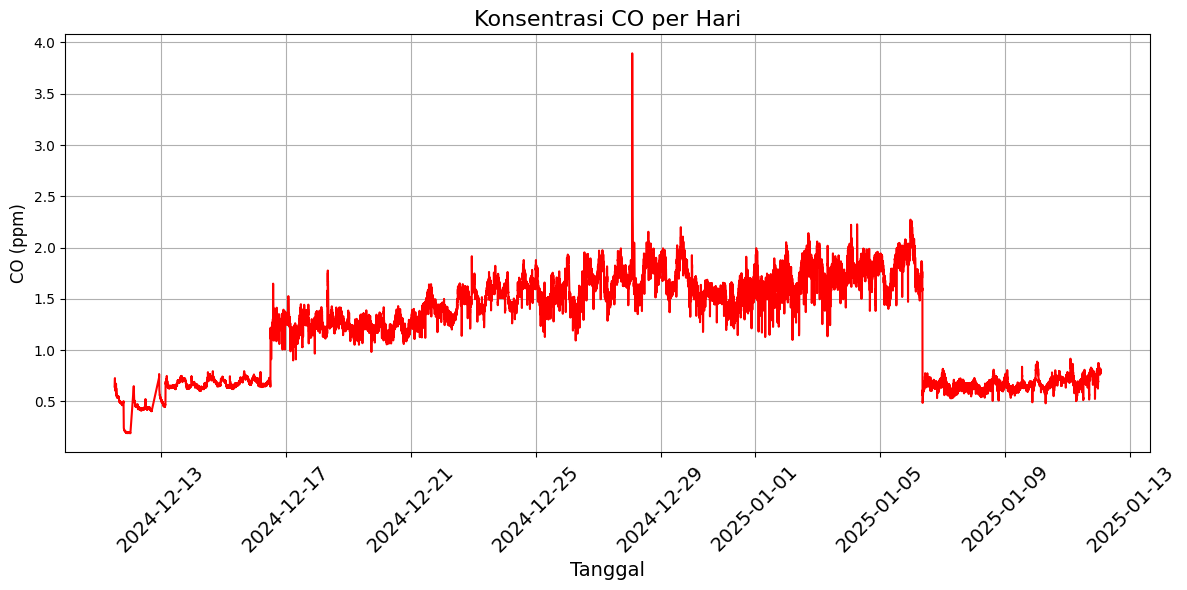

In [24]:
plt.figure(figsize=(12, 6))  # Ukuran besar agar resolusi bagus
sns.lineplot(data=df_per_2menit, x='created_at', y='CO', color='red', markers='o')

# Tambahan estetika
plt.title('Konsentrasi CO per Hari', fontsize=16)
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('CO (ppm)', fontsize=12)
plt.xticks(rotation=45, fontsize=14)
plt.grid(True)

# Simpan dalam kualitas tinggi
plt.tight_layout()
plt.savefig("co_plot.png", dpi=300)
plt.show()

In [25]:
df_per_2menit.describe()

,CO2,CO
count,22402.000000,22402.000000
mean,410.319197,1.247042
std,11.854529,0.470648
min,400.070000,0.188571
25%,403.085952,0.702857
50%,406.693810,1.347500
75%,413.660937,1.632000
max,552.592857,3.894286


Correlation plot antara dua variabel tanpa adanya entry_id

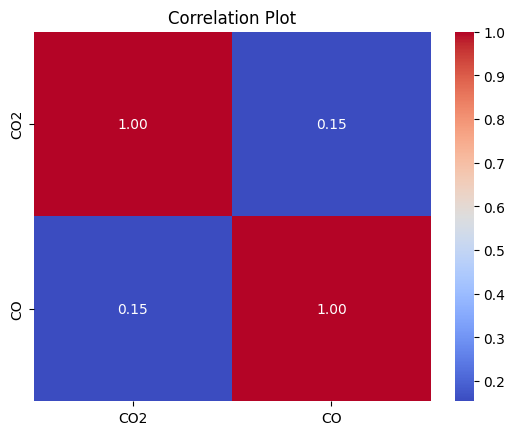

In [26]:
correlation = df_per_2menit[['CO2', 'CO']].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Plot')
plt.show()

Berikut adalah distribusi dari dari CO2 dan CO

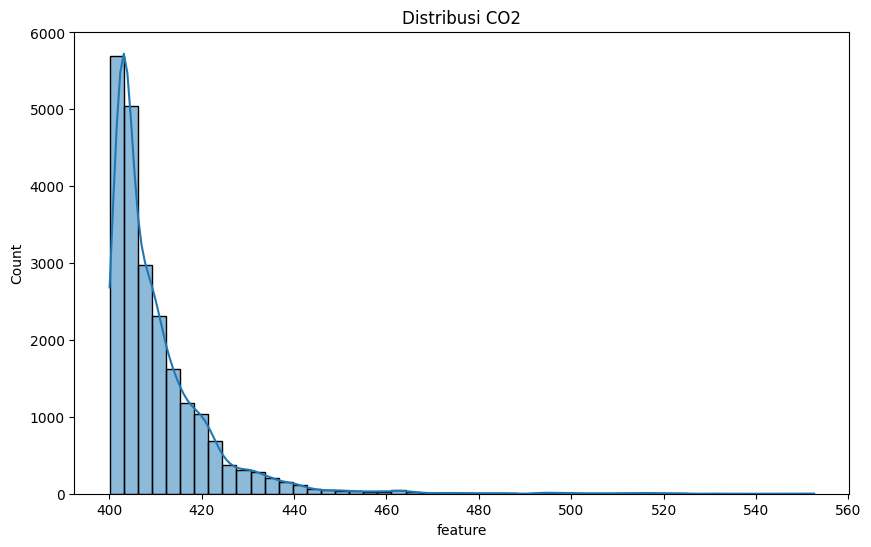

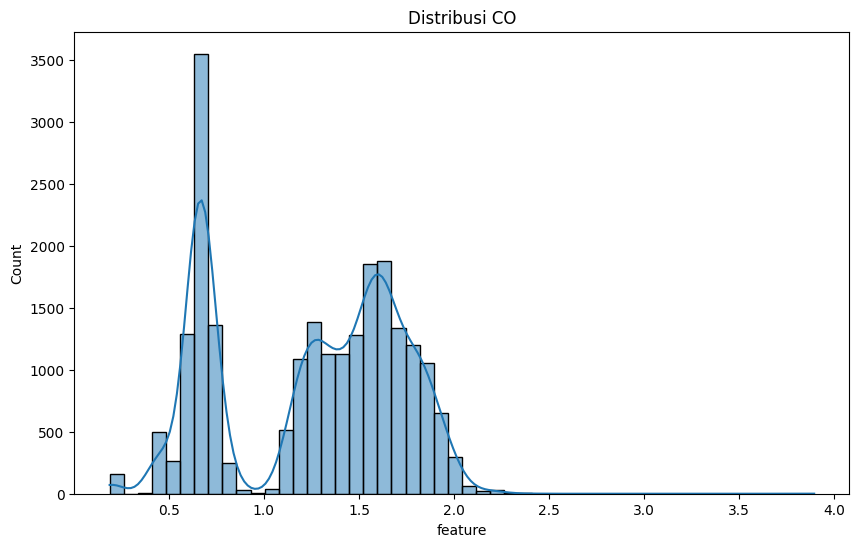

In [27]:
numeric_feature = ["CO2", "CO"]

for feature in numeric_feature:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_per_2menit[feature], kde=True, bins=50)
    plt.title(f"Distribusi {feature}")
    plt.xlabel("feature")

Graf boxplot dari CO2 dan CO yang masih menunjukkan adanya outliers yang akan di bersihkan pada data preprocessing

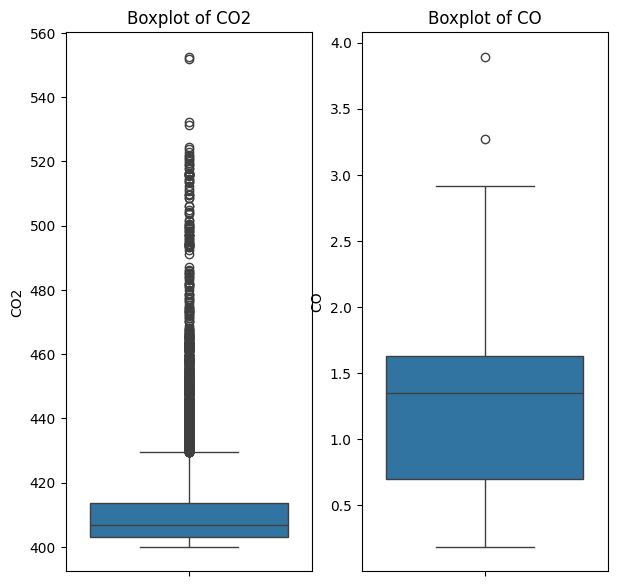

In [28]:
plt.figure(figsize=(7, 7))

plt.subplot2grid((2, 2), (0, 0), rowspan=2, colspan=1)
sns.boxplot( df_per_2menit['CO2'], label='CO2')
plt.title("Boxplot of CO2")


plt.subplot2grid((2, 2), (0, 1), rowspan=2, colspan=1)
sns.boxplot(df_per_2menit['CO'], label='CO')
plt.title("Boxplot of CO")
plt.show()

## **Preprocessing Data**

Melakukan pengecekan terhadap missing values

In [29]:
df_per_2menit.isnull().sum()

CO2    294
CO     294
dtype: int64

In [30]:
df_per_2menit.duplicated().sum()

328

Melakukan imputasi terhadap missing value dengan interpolate untuk mencegah semakin mengecilnya ukuran data untuk training

In [31]:
df_per_2menit = df_per_2menit.interpolate(method='time')

In [32]:
df_per_2menit.isnull().sum()

CO2    0
CO     0
dtype: int64

In [33]:
df_per_2menit.duplicated().sum()

35

In [40]:
df_per_2menit[df_per_2menit.duplicated(keep=False)]

,CO2,CO
created_at,,
2024-12-11 13:48:00+00:00,400.568333,0.633333
2024-12-11 16:20:00+00:00,400.280000,0.495000
2024-12-11 17:04:00+00:00,400.280000,0.495000
2024-12-11 19:06:00+00:00,400.182857,0.478571
2024-12-11 19:16:00+00:00,400.180000,0.487143
...,...,...
2024-12-26 02:56:00+00:00,403.452857,1.435714
2024-12-29 10:00:00+00:00,403.016250,1.591250
2024-12-30 21:42:00+00:00,403.016250,1.591250


In [35]:
df.index.duplicated().sum()

0

Data duplikat tidak dihapus dikarenakan data duplikat tersebut merupakan data CO2 dan CO yang sama namun bukan timestamp yang sama

Melakukan normalisasi

In [38]:
scaler = MinMaxScaler()
df_regresi = df_per_2menit.copy()
df_regresi[['CO2', 'CO']] = scaler.fit_transform(df_per_2menit[['CO2', 'CO']])
df_regresi.head(3)

,CO2,CO
created_at,,
2024-12-11 12:40:00+00:00,0.017593,0.122719
2024-12-11 12:42:00+00:00,0.017211,0.123506
2024-12-11 12:44:00+00:00,0.017418,0.125867


Data Splitting untuk algoritma regressi

In [46]:
X_CO2 = df_regresi[['CO2']]   # fitur
y_CO = df_regresi['CO']      # target

X_train_CO2, X_test_CO2, y_train_CO, y_test_CO = train_test_split(X_CO2, y_CO, test_size=0.2, random_state=42)

In [47]:
X_CO = df_regresi[['CO']]   # fitur
y_CO2 = df_regresi['CO2']      # target

X_train_CO, X_test_CO, y_train_CO2, y_test_CO2 = train_test_split(X_CO, y_CO2, test_size=0.2, random_state=42)

## **Pemodelan dengan Machine Learning Klasik**

### **Linear Regression**

Pelatihan untuk model prediksi CO

In [57]:
model_lr_CO = LinearRegression()
model_lr_CO.fit(X_train_CO2, y_train_CO)

LinearRegression()

In [58]:
y_pred_lr_CO = model_lr_CO.predict(X_test_CO2)
rmse_lr_CO = mean_squared_error(y_test_CO, y_pred_lr_CO, squared=False)
mse_lr_CO = mean_squared_error(y_test_CO, y_pred_lr_CO)
mae_lr_CO = mean_absolute_error(y_test_CO, y_pred_lr_CO)
print("Hasil Evaluasi Model Linear Regression (CO ~ CO2):")
print(f"RMSE (Root Mean Squared Error)     : {rmse_lr_CO:.4f}")
print(f"MSE  (Mean Squared Error)          : {mse_lr_CO:.4f}")
print(f"MAE  (Mean Absolute Error)         : {mae_lr_CO:.4f}")

Hasil Evaluasi Model Linear Regression (CO ~ CO2):
RMSE (Root Mean Squared Error)     : 0.1256
MSE  (Mean Squared Error)          : 0.0158
MAE  (Mean Absolute Error)         : 0.1101


c:\Users\Muhammad Mahdi\anaconda3\envs\main-ds\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Pelatihan untuk model prediksi CO2

In [59]:
model_lr_CO2 = LinearRegression()
model_lr_CO2.fit(X_train_CO, y_train_CO2)

LinearRegression()

In [63]:
y_pred_lr_CO2 = model_lr_CO2.predict(X_test_CO)

rmse_lr_CO2 = mean_squared_error(y_test_CO2, y_pred_lr_CO2, squared=False)
mse_lr_CO2 = mean_squared_error(y_test_CO2, y_pred_lr_CO2)
mae_lr_CO2 = mean_absolute_error(y_test_CO2, y_pred_lr_CO2)

print("Hasil Evaluasi Model Linear Regression (CO2 ~ CO):")
print(f"RMSE (Root Mean Squared Error)     : {rmse_lr_CO2:.4f}")
print(f"MSE  (Mean Squared Error)          : {mse_lr_CO2:.4f}")
print(f"MAE  (Mean Absolute Error)         : {mae_lr_CO2:.4f}")

Hasil Evaluasi Model Linear Regression (CO2 ~ CO):
RMSE (Root Mean Squared Error)     : 0.0763
MSE  (Mean Squared Error)          : 0.0058
MAE  (Mean Absolute Error)         : 0.0500


c:\Users\Muhammad Mahdi\anaconda3\envs\main-ds\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


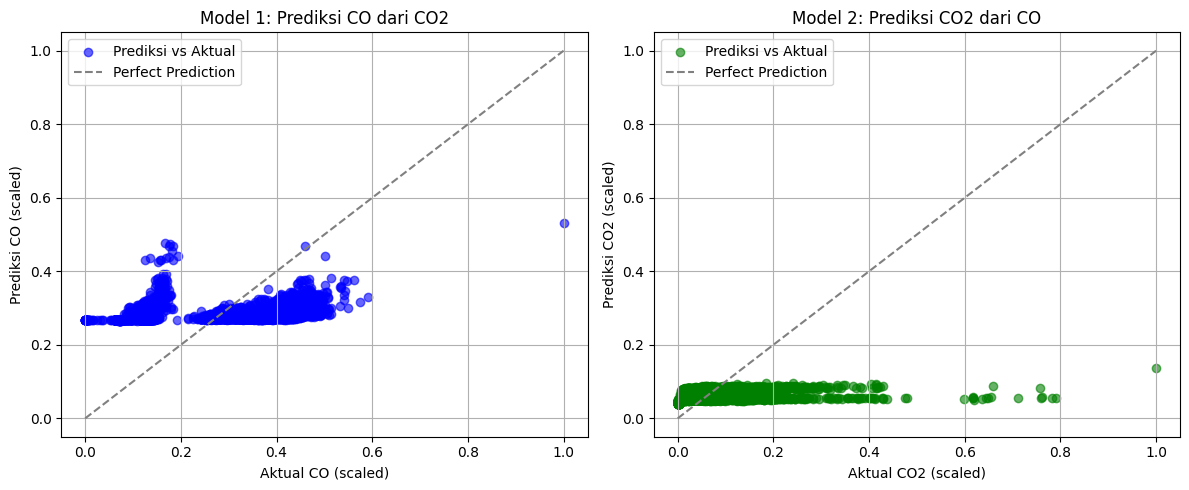

In [64]:
import matplotlib.pyplot as plt

# === Model 1: CO ~ CO2 ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_CO, y_pred_lr_CO, alpha=0.6, color='blue', label='Prediksi vs Aktual')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Prediction')  # garis y = x
plt.title('Model 1: Prediksi CO dari CO2')
plt.xlabel('Aktual CO (scaled)')
plt.ylabel('Prediksi CO (scaled)')
plt.grid(True)
plt.legend()

# === Model 2: CO2 ~ CO ===
plt.subplot(1, 2, 2)
plt.scatter(y_test_CO2, y_pred_lr_CO2, alpha=0.6, color='green', label='Prediksi vs Aktual')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Prediction')
plt.title('Model 2: Prediksi CO2 dari CO')
plt.xlabel('Aktual CO2 (scaled)')
plt.ylabel('Prediksi CO2 (scaled)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### **Decision Tree Regressor**

Pelatihan untuk model prediksi CO

In [66]:
model_tree_CO = DecisionTreeRegressor(random_state=42)
model_tree_CO.fit(X_train_CO2, y_train_CO)

DecisionTreeRegressor(random_state=42)

In [69]:
y_pred_tree_CO = model_tree_CO.predict(X_test_CO2)

print("Decision Tree: Prediksi CO dari CO2")
print(f"RMSE: {mean_squared_error(y_test_CO, y_pred_tree_CO, squared=False):.4f}")
print(f"MSE : {mean_squared_error(y_test_CO, y_pred_tree_CO):.4f}")
print(f"MAE : {mean_absolute_error(y_test_CO, y_pred_tree_CO):.4f}")

Decision Tree: Prediksi CO dari CO2
RMSE: 0.1490
MSE : 0.0222
MAE : 0.1090


c:\Users\Muhammad Mahdi\anaconda3\envs\main-ds\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Pelatihan untuk model prediksi CO2

In [70]:
model_tree_CO2 = DecisionTreeRegressor(random_state=42)
model_tree_CO2.fit(X_train_CO, y_train_CO2)

DecisionTreeRegressor(random_state=42)

In [71]:
y_pred_tree_CO2 = model_tree_CO2.predict(X_test_CO)

print("Decision Tree: Prediksi CO2 dari CO")
print(f"RMSE: {mean_squared_error(y_test_CO2, y_pred_tree_CO2, squared=False):.4f}")
print(f"MSE : {mean_squared_error(y_test_CO2, y_pred_tree_CO2):.4f}")
print(f"MAE : {mean_absolute_error(y_test_CO2, y_pred_tree_CO2):.4f}")
print(f"R²  : {r2_score(y_test_CO2, y_pred_tree_CO2):.4f}")

Decision Tree: Prediksi CO2 dari CO
RMSE: 0.0639
MSE : 0.0041
MAE : 0.0406
R²  : 0.3207


c:\Users\Muhammad Mahdi\anaconda3\envs\main-ds\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


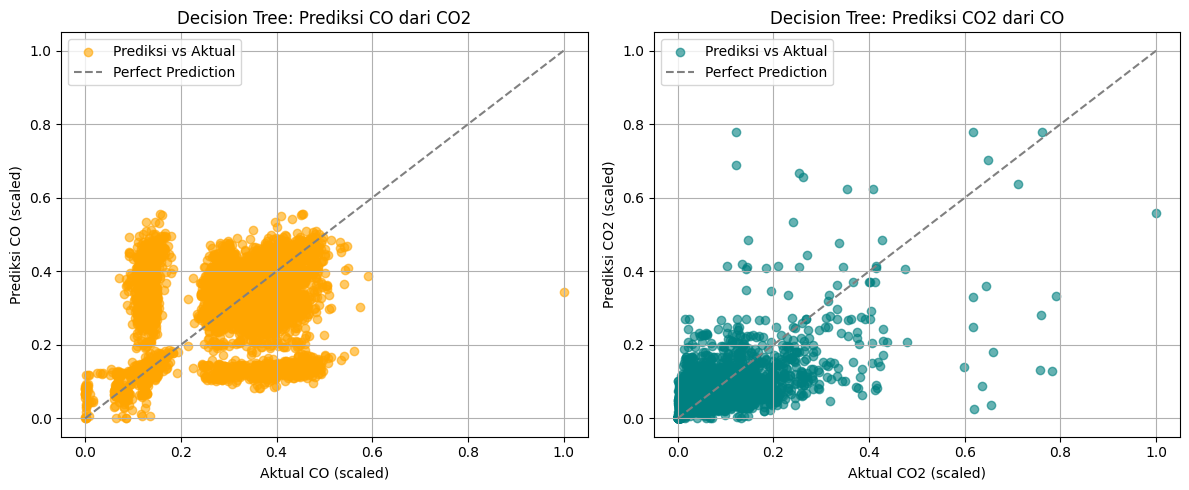

In [72]:
plt.figure(figsize=(12, 5))

# === Model 1: Prediksi CO dari CO2 ===
plt.subplot(1, 2, 1)
plt.scatter(y_test_CO, y_pred_tree_CO, alpha=0.6, color='orange', label='Prediksi vs Aktual')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Prediction')
plt.title('Decision Tree: Prediksi CO dari CO2')
plt.xlabel('Aktual CO (scaled)')
plt.ylabel('Prediksi CO (scaled)')
plt.grid(True)
plt.legend()

# === Model 2: Prediksi CO2 dari CO ===
plt.subplot(1, 2, 2)
plt.scatter(y_test_CO2, y_pred_tree_CO2, alpha=0.6, color='teal', label='Prediksi vs Aktual')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Prediction')
plt.title('Decision Tree: Prediksi CO2 dari CO')
plt.xlabel('Aktual CO2 (scaled)')
plt.ylabel('Prediksi CO2 (scaled)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### **Random Forest Regressor**

Pelatihan untuk model prediksi CO

In [73]:
model_rf_CO = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_CO.fit(X_train_CO2, y_train_CO)

RandomForestRegressor(random_state=42)

In [75]:
y_pred_rf_CO = model_rf_CO.predict(X_test_CO2)

print("\n🌲 Random Forest: Prediksi CO dari CO2")
print(f"RMSE: {mean_squared_error(y_test_CO, y_pred_rf_CO, squared=False):.4f}")
print(f"MSE : {mean_squared_error(y_test_CO, y_pred_rf_CO):.4f}")
print(f"MAE : {mean_absolute_error(y_test_CO, y_pred_rf_CO):.4f}")


🌲 Random Forest: Prediksi CO dari CO2
RMSE: 0.1306
MSE : 0.0171
MAE : 0.0989


c:\Users\Muhammad Mahdi\anaconda3\envs\main-ds\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Pelatihan untuk model prediksi CO2

In [76]:
model_rf_CO2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_CO2.fit(X_train_CO, y_train_CO2)

RandomForestRegressor(random_state=42)

In [77]:
y_pred_rf_CO2 = model_rf_CO2.predict(X_test_CO)

print("Random Forest: Prediksi CO2 dari CO")
print(f"RMSE: {mean_squared_error(y_test_CO2, y_pred_rf_CO2, squared=False):.4f}")
print(f"MSE : {mean_squared_error(y_test_CO2, y_pred_rf_CO2):.4f}")
print(f"MAE : {mean_absolute_error(y_test_CO2, y_pred_rf_CO2):.4f}")

Random Forest: Prediksi CO2 dari CO
RMSE: 0.0625
MSE : 0.0039
MAE : 0.0401


c:\Users\Muhammad Mahdi\anaconda3\envs\main-ds\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


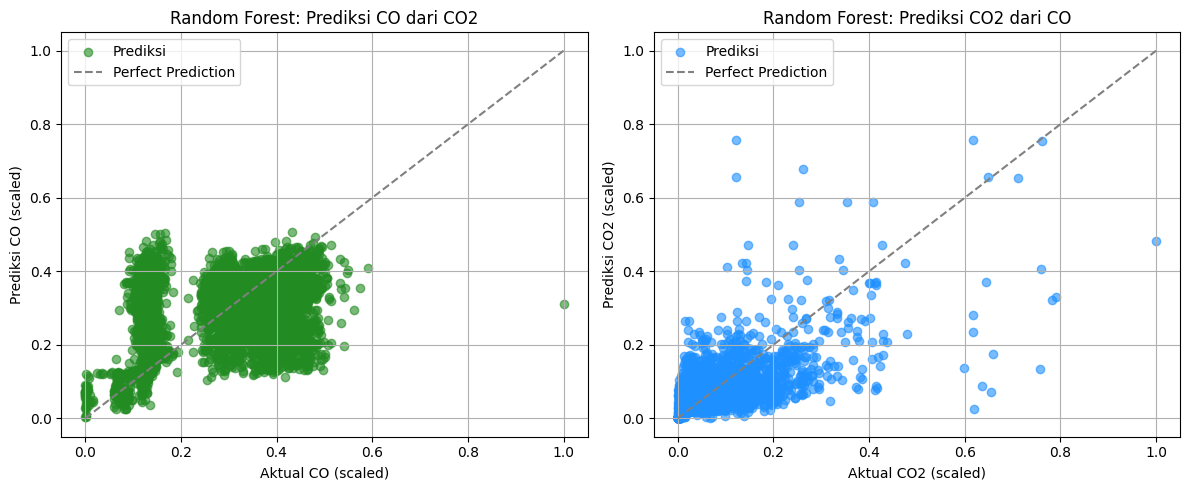

In [82]:
plt.figure(figsize=(12, 5))

# === Model 1: Prediksi CO dari CO2 ===
plt.subplot(1, 2, 1)
plt.scatter(y_test_CO, y_pred_rf_CO, alpha=0.6, color='forestgreen', label='Prediksi')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Prediction')  # y = x line
plt.title('Random Forest: Prediksi CO dari CO2')
plt.xlabel('Aktual CO (scaled)')
plt.ylabel('Prediksi CO (scaled)')
plt.grid(True)
plt.legend()

# === Model 2: Prediksi CO2 dari CO ===
plt.subplot(1, 2, 2)
plt.scatter(y_test_CO2, y_pred_rf_CO2, alpha=0.6, color='dodgerblue', label='Prediksi')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Prediction')
plt.title('Random Forest: Prediksi CO2 dari CO')
plt.xlabel('Aktual CO2 (scaled)')
plt.ylabel('Prediksi CO2 (scaled)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

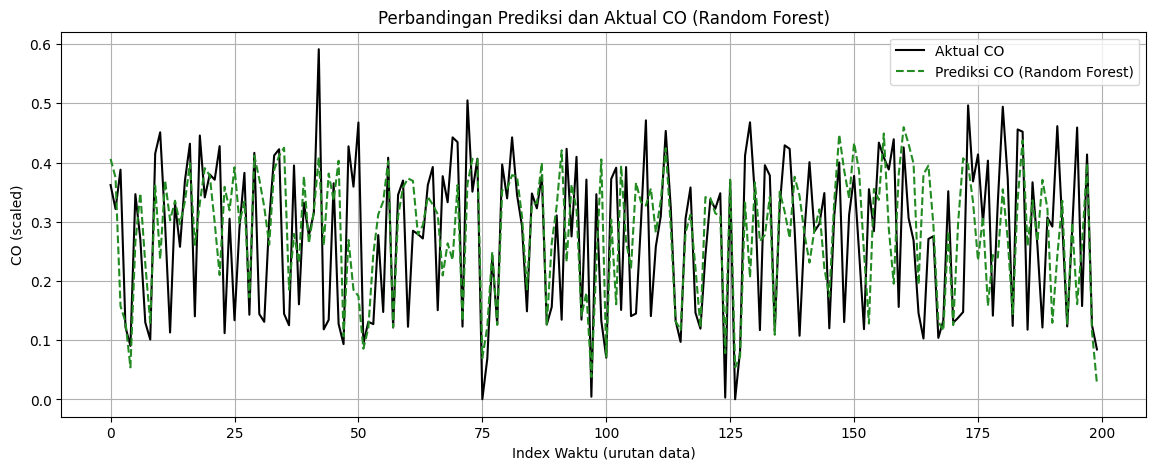

In [83]:
# Misalnya kita ambil 200 data pertama agar tidak terlalu padat
n = 200
x_axis = np.arange(n)

plt.figure(figsize=(14, 5))
plt.plot(x_axis, y_test_CO[:n].values, label='Aktual CO', color='black', linestyle='-')
plt.plot(x_axis, y_pred_rf_CO[:n], label='Prediksi CO (Random Forest)', color='forestgreen', linestyle='--')
plt.title('Perbandingan Prediksi dan Aktual CO (Random Forest)')
plt.xlabel('Index Waktu (urutan data)')
plt.ylabel('CO (scaled)')
plt.legend()
plt.grid(True)
plt.show()

## **Pemodelan Menggunakan LSTM**

In [24]:
df_per_2menit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22696 entries, 2024-12-11 12:40:00+00:00 to 2025-01-12 01:10:00+00:00
Freq: 2min
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   entry_id  22696 non-null  float64
 1   CO2       22696 non-null  float64
 2   CO        22696 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


In [25]:
df_per_2menit.describe()

,entry_id,CO2,CO
count,22696.000000,22696.000000,22696.000000
mean,80584.341426,410.209353,1.238428
std,46850.421153,11.820341,0.474403
min,2.000000,400.070000,0.190000
25%,39890.625000,403.010000,0.700000
50%,81148.750000,406.540000,1.340000
75%,121346.625000,413.550000,1.630000
max,160785.000000,552.590000,3.890000


In [26]:
df_per_2menit.head(1)

,entry_id,CO2,CO
created_at,,,
2024-12-11 12:40:00+00:00,2.0,402.75,0.64


In [35]:
df_per_2menit.duplicated().sum()

35

In [28]:
df_per_2menit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22696 entries, 2024-12-11 12:40:00+00:00 to 2025-01-12 01:10:00+00:00
Freq: 2min
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   entry_id  22696 non-null  float64
 1   CO2       22696 non-null  float64
 2   CO        22696 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


### **Multivariat Multi Step Forecasting**

In [29]:
df_per_2menit = df_per_2menit.drop(columns=['entry_id'])

In [30]:
# Tentukan proporsi
n = len(df_per_2menit)
train_size = int(n * 0.7)
val_size = int(n * 0.15)

# Split berdasarkan urutan waktu
train_df = df_per_2menit.iloc[:train_size]
val_df   = df_per_2menit.iloc[train_size:train_size + val_size]
test_df  = df_per_2menit.iloc[train_size + val_size:]


In [31]:
val_df

,CO2,CO
created_at,,
2025-01-02 14:14:00+00:00,408.02,1.83
2025-01-02 14:16:00+00:00,408.11,1.83
2025-01-02 14:18:00+00:00,408.04,1.91
2025-01-02 14:20:00+00:00,408.63,1.86
2025-01-02 14:22:00+00:00,408.19,1.82
...,...,...
2025-01-07 07:32:00+00:00,404.30,0.60
2025-01-07 07:34:00+00:00,404.42,0.57
2025-01-07 07:36:00+00:00,404.09,0.61


In [32]:
test_df

,CO2,CO
created_at,,
2025-01-07 07:42:00+00:00,403.98,0.59
2025-01-07 07:44:00+00:00,404.09,0.59
2025-01-07 07:46:00+00:00,403.65,0.60
2025-01-07 07:48:00+00:00,403.25,0.59
2025-01-07 07:50:00+00:00,402.72,0.60
...,...,...
2025-01-12 01:02:00+00:00,430.33,0.80
2025-01-12 01:04:00+00:00,428.32,0.80
2025-01-12 01:06:00+00:00,430.19,0.80


In [76]:
scaler = MinMaxScaler()
scaler.fit(train_df)

# 3. Transform semua data
train_scaled = scaler.transform(train_df)
valid_scaled = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df.iloc[:-15])

### Melakukan window splitting

In [34]:
tf.random.set_seed(42)

# Membuat fungsi untuk split data input dan target
def split_inputs_and_targets(mulvar_series, ahead=10, target_cols=[0, 1]):
    # input semua timestamp kecuali 10 langkah ke depan
    X = mulvar_series[:, :-ahead, :]

    # output: nilai aktual untuk 10 langkah kedepan
    Y = mulvar_series[:, -ahead:, :]
    Y = tf.gather(Y, target_cols, axis=-1)  # ambil hanya fitur target (CO2 dan CO)
    
    return X, Y

In [35]:
seq_length = 30

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_scaled,
    targets=None,
    sequence_length=seq_length + 10,
    batch_size=32,
    shuffle=True
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid_scaled,
    targets=None,
    sequence_length=seq_length + 10,
    batch_size=32,
    shuffle=True
).map(split_inputs_and_targets)

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    test_scaled,
    targets=None,
    sequence_length=seq_length + 10,  # 30 input + 10 output
    batch_size=32,
    shuffle=False
).map(split_inputs_and_targets)  # target [1,2] = CO2 & CO


In [77]:

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=test_scaled,
    targets=None,
    sequence_length=seq_length + 10,  # contoh: 30 + 10 = 40
    batch_size=32,
    shuffle=False
).map(split_inputs_and_targets)


In [37]:
tf.keras.backend.clear_session()

In [38]:
# tf.keras.backend.clear_session()
tf.random.set_seed(42)

mulvar_multask_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(None, 2)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(10 * 2),
    tf.keras.layers.Reshape((10, 2))
])

In [39]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=10, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_mae")

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
mulvar_multask_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [40]:
mulvar_multask_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4480      
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 20)                660       
                                                                 
 reshape (Reshape)           (None, 10, 2)             0         
                                                                 
Total params: 21,780
Trainable params: 21,780
Non-trainable params: 0
_________________________________________________________________


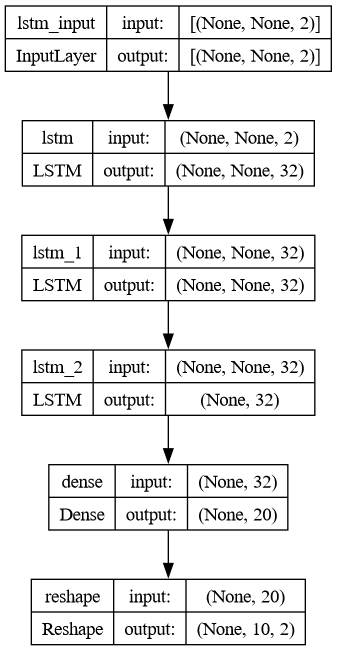

In [41]:
tf.keras.utils.plot_model(mulvar_multask_model, show_shapes=True)

In [42]:
with tf.device('/GPU:0'):
    history = mulvar_multask_model.fit(ahead_train_ds, epochs=30, validation_data=ahead_valid_ds, callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/30
496/496 [==============================] - 10s 12ms/step - loss: 0.0051 - mae: 0.0718 - val_loss: 0.0063 - val_mae: 0.0905
Epoch 2/30
496/496 [==============================] - 5s 11ms/step - loss: 0.0028 - mae: 0.0530 - val_loss: 0.0037 - val_mae: 0.0657
Epoch 3/30
496/496 [==============================] - 5s 11ms/step - loss: 0.0011 - mae: 0.0330 - val_loss: 0.0025 - val_mae: 0.0486
Epoch 4/30
496/496 [==============================] - 5s 11ms/step - loss: 7.9188e-04 - mae: 0.0260 - val_loss: 0.0023 - val_mae: 0.0447
Epoch 5/30
496/496 [==============================] - 5s 11ms/step - loss: 7.3191e-04 - mae: 0.0240 - val_loss: 0.0023 - val_mae: 0.0435
Epoch 6/30
496/496 [==============================] - 5s 11ms/step - loss: 7.1502e-04 - mae: 0.0234 - val_loss: 0.0022 - val_mae: 0.0431
Epoch 7/30
496/496 [==============================] - 5s 11ms/step - loss: 7.0588e-04 - mae: 0.0231 - val_loss: 0.0022 - val_mae: 0.0427
Epoch 8/30
496/496 [==============================] 

In [43]:
valid_loss, valid_mae = mulvar_multask_model.evaluate(ahead_valid_ds)

106/106 [==============================] - 1s 5ms/step - loss: 0.0010 - mae: 0.0268


In [44]:
y_pred = mulvar_multask_model.predict(ahead_test_ds)  # hasil: shape (batch, 10, 2)

106/106 [==============================] - 1s 5ms/step


In [45]:
import numpy as np

y_true = np.concatenate([y.numpy() for _, y in ahead_test_ds], axis=0)


In [46]:
# Pastikan scaler_y sudah di-fit ke train_df[['field1', 'field2']]
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 2)).reshape(y_pred.shape)
y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 2)).reshape(y_true.shape)


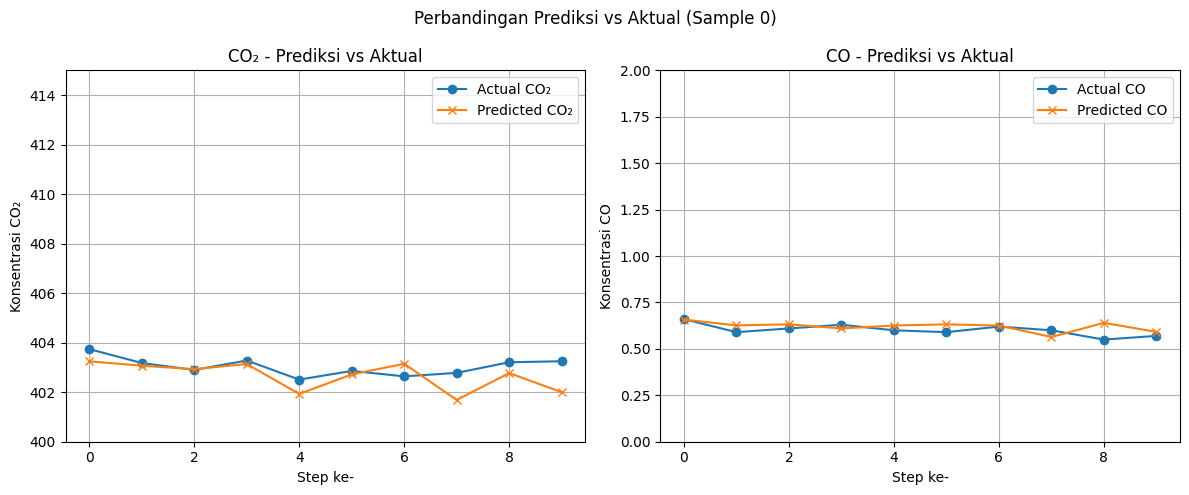

In [66]:
import matplotlib.pyplot as plt

sample_index = 0  # bisa diganti ke 1, 2, dst.

plt.figure(figsize=(12, 5))

# Plot CO₂ (index 0)
plt.subplot(1, 2, 1)
plt.plot(y_true_orig[sample_index, :, 0], label='Actual CO₂', marker='o')
plt.plot(y_pred_orig[sample_index, :, 0], label='Predicted CO₂', marker='x')
plt.title('CO₂ - Prediksi vs Aktual')
plt.xlabel('Step ke-')
plt.ylabel('Konsentrasi CO₂')
plt.ylim(400, 415)
plt.legend()
plt.grid(True)

# Plot CO (index 1)
plt.subplot(1, 2, 2)
plt.plot(y_true_orig[sample_index, :, 1], label='Actual CO', marker='o')
plt.plot(y_pred_orig[sample_index, :, 1], label='Predicted CO', marker='x')
plt.title('CO - Prediksi vs Aktual')
plt.xlabel('Step ke-')
plt.ylabel('Konsentrasi CO')
plt.ylim(0, 2)
plt.legend()
plt.grid(True)

plt.suptitle(f'Perbandingan Prediksi vs Aktual (Sample {sample_index})')
plt.tight_layout()
plt.show()


## **Hyper Parameter Tuning**

In [51]:
import keras_tuner as kt

In [52]:
# tf.keras.backend.clear_session()

In [53]:
def build_model(hp):
    model_lstm_tuned = tf.keras.Sequential()
    # Hyperparameter: jumlah neuron di LSTM, dan jumlah layer LSTM
    n_lstm_units = hp.Int("n_units", min_value=8, max_value=256)
    n_lstm_layers = hp.Int("n_lstm_layers", min_value=1, max_value=4)
    
    model_lstm_tuned.add(tf.keras.layers.Input(shape=(30, 2)))  # 30 time steps, 2 features
    for i in range(n_lstm_layers):
        return_seq = i < n_lstm_layers - 1 # mengecek apakah ini layer terakhir atau bukan
        model_lstm_tuned.add(tf.keras.layers.LSTM(units=n_lstm_units, return_sequences=return_seq))
        if hp.Boolean(f"use_dropout_{i}"):
            model_lstm_tuned.add(tf.keras.layers.Dropout(rate=hp.Float(f"dropout_rate_{i}", 0.1, 0.5)))
    
    model_lstm_tuned.add(tf.keras.layers.Dense(10 * 2)) # 10 langkah kedepan, 2 fitur
    model_lstm_tuned.add(tf.keras.layers.Reshape((10, 2)))  # reshape ke (10, 2)

    # Optimizer
    learning_rate = hp.Float("learning_rate", 1e-5, 1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", ["adam", "sgd"])
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    # compile model
    model_lstm_tuned.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=['mae']
    )
    return model_lstm_tuned


**Menambahkan Tensor Board Callbacks untuk visualisasi Performa model**

In [54]:
from tensorflow.keras.callbacks import TensorBoard
from pathlib import Path
import datetime

# Gunakan folder dari tuner + subfolder tensorboard
project_dir = Path("LSTM_tuner_results") / "LSTM_tuning"
timestamp = datetime.datetime.now().strftime("run_%Y_%m_%d_%H_%M_%S")
log_dir = project_dir / "tensorboard" / timestamp

# Callback TensorBoard
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)


**Menambahkan early stopping untuk mencegah overfitting**

In [55]:
early_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=10, restore_best_weights=True)

In [56]:
lstm_random_search_tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    overwrite=True,
    directory='LSTM_tuner_results',
    project_name='LSTM_tuning',
    seed=42
)

In [57]:
# Lakukan tuning dengan callbacks
with tf.device('/GPU:0'):
    lstm_random_search_tuner.search(
    ahead_train_ds,
    validation_data=ahead_valid_ds,
    epochs=30,
    callbacks=[tensorboard_cb, early_cb]
    )

Trial 10 Complete [00h 01m 45s]
val_mae: 0.034582365304231644

Best val_mae So Far: 0.01546227652579546
Total elapsed time: 00h 25m 49s


In [58]:
top_3models = lstm_random_search_tuner.get_best_models(num_models=3)
best_model = top_3models[0]

In [59]:
best_model

In [60]:
top3_params = lstm_random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_units': 63,
 'n_lstm_layers': 2,
 'use_dropout_0': False,
 'learning_rate': 0.006080995718468771,
 'optimizer': 'adam',
 'use_dropout_1': False,
 'use_dropout_2': False,
 'dropout_rate_0': 0.12832357082362905,
 'dropout_rate_2': 0.1299175027492443}

In [61]:
best_trial = lstm_random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 03 summary
Hyperparameters:
n_units: 63
n_lstm_layers: 2
use_dropout_0: False
learning_rate: 0.006080995718468771
optimizer: adam
use_dropout_1: False
use_dropout_2: False
dropout_rate_0: 0.12832357082362905
dropout_rate_2: 0.1299175027492443
Score: 0.01546227652579546


In [62]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 63)            16632     
                                                                 
 lstm_1 (LSTM)               (None, 63)                32004     
                                                                 
 dense (Dense)               (None, 20)                1280      
                                                                 
 reshape (Reshape)           (None, 10, 2)             0         
                                                                 
Total params: 49,916
Trainable params: 49,916
Non-trainable params: 0
_________________________________________________________________


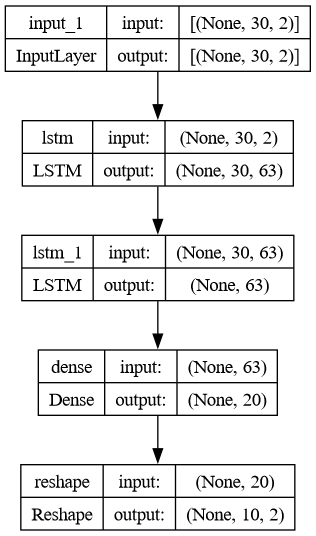

In [63]:
tf.keras.utils.plot_model(best_model, show_shapes=True)

In [64]:
best_model.save("lstm_best_model_rndsearch.h5")


In [65]:
# save model dalam tensorflow format
best_model.save("saved_model/lstm_best_model_rndsearch")

INFO:tensorflow:Assets written to: saved_model/lstm_best_model_rndsearch\assets


INFO:tensorflow:Assets written to: saved_model/lstm_best_model_rndsearch\assets


In [ ]:
y_pred = best_model.predict(ahead_test_ds)  # hasil: shape (batch, 10, 2)

105/105 [==============================] - 1s 6ms/step


In [102]:
val_loss, val_mae = best_model.evaluate(ahead_valid_ds)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

106/106 [==============================] - 1s 7ms/step - loss: 4.1386e-04 - mae: 0.0155
Validation Loss: 0.0004138585936743766, Validation MAE: 0.015462278388440609


In [85]:
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 2)).reshape(y_pred.shape)

In [86]:
last_time = test_df.index[-16]  # karena test_df_limited = iloc[:-15]

In [87]:
future_times = pd.date_range(start=last_time + pd.Timedelta(minutes=2), periods=10, freq='2min')

In [89]:
last_y_pred_orig = y_pred_orig[-1]  # shape: (10, 2)

df_pred = pd.DataFrame(last_y_pred_orig, index=future_times, columns=['CO2_pred', 'CO_pred'])



In [90]:
df_pred

,CO2_pred,CO_pred
2025-01-12 00:42:00+00:00,447.377716,0.929485
2025-01-12 00:44:00+00:00,448.712311,0.855656
2025-01-12 00:46:00+00:00,446.221710,0.799052
2025-01-12 00:48:00+00:00,442.355286,0.906466
2025-01-12 00:50:00+00:00,431.025848,0.831598
2025-01-12 00:52:00+00:00,434.181915,0.922170
2025-01-12 00:54:00+00:00,432.288544,0.769182
2025-01-12 00:56:00+00:00,429.444397,0.885705
2025-01-12 00:58:00+00:00,424.702393,0.890727
2025-01-12 01:00:00+00:00,425.540283,0.921914


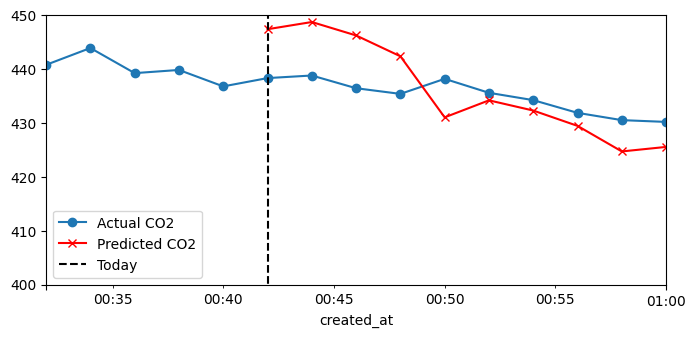

In [109]:
fig, ax = plt.subplots(figsize=(8, 3.5))
test_df["2025-01-12 00:32:00+00:00":"2025-01-12 01:00:00+00:00"].plot(ax=ax, y='CO2', label='Actual CO2', marker='o')
df_pred.plot(ax=ax, y='CO2_pred', label='Predicted CO2', marker='x', color='r')
ax.vlines("2025-01-12 00:42:00+00:00", 0, 500, color="k", linestyle="--", label="Today")
plt.ylim(400, 450)
plt.legend(loc='lower left')
plt.show()


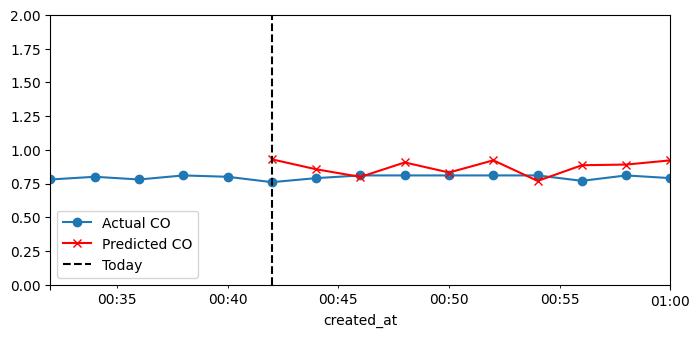

In [112]:
fig, ax = plt.subplots(figsize=(8, 3.5))
test_df["2025-01-12 00:32:00+00:00":"2025-01-12 01:00:00+00:00"].plot(ax=ax, y='CO', label='Actual CO', marker='o')
df_pred.plot(ax=ax, y='CO_pred', label='Predicted CO', marker='x', color='r')
plt.ylim(0,2)
ax.vlines("2025-01-12 00:42:00+00:00", 0, 10, color="k", linestyle="--", label="Today")
plt.legend(loc='lower left')
plt.show()

In [ ]:
test_df.iloc[-:]

,CO2,CO
created_at,,
2025-01-12 00:42:00+00:00,438.31,0.76
2025-01-12 00:44:00+00:00,438.79,0.79
2025-01-12 00:46:00+00:00,436.43,0.81
2025-01-12 00:48:00+00:00,435.38,0.81
2025-01-12 00:50:00+00:00,438.17,0.81
2025-01-12 00:52:00+00:00,435.58,0.81
2025-01-12 00:54:00+00:00,434.22,0.81
2025-01-12 00:56:00+00:00,431.86,0.77
2025-01-12 00:58:00+00:00,430.51,0.81


In [91]:
test_df.tail(30)

,CO2,CO
created_at,,
2025-01-12 00:12:00+00:00,462.39,0.82
2025-01-12 00:14:00+00:00,461.58,0.82
2025-01-12 00:16:00+00:00,456.10,0.83
2025-01-12 00:18:00+00:00,457.22,0.81
2025-01-12 00:20:00+00:00,450.90,0.81
2025-01-12 00:22:00+00:00,451.63,0.79
2025-01-12 00:24:00+00:00,453.09,0.76
2025-01-12 00:26:00+00:00,448.09,0.80
2025-01-12 00:28:00+00:00,447.77,0.80
